# NNDL miniproj3 Question1-Bonus: Efficient Net Transfer Learning
sajjad pakdaman    [810195517]

fatemeh haghighi   [810195385]

## setup
import necessary libs

In [ ]:
# install tf_nighty
! pip3 install tf-nightly

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import plot_model

## load MNIST

In [ ]:
(f_tra, l_tra), (f_tes, l_tes) = keras.datasets.mnist.load_data()

In [ ]:
img_width, img_height = f_tra.shape[1], f_tra.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

Text(0.5, 1.0, '5')

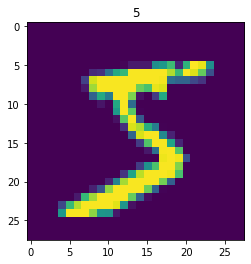

In [ ]:
plt.imshow(f_tra[0])
plt.title(l_tra[0])

## Data preprocessing


In [ ]:
# Parse numbers as floats
f_tra = (f_tra.astype('float32') / 255).reshape(f_tra.shape[0], img_height, img_width, num_channels)
f_tes = (f_tes.astype('float32') / 255).reshape(f_tes.shape[0], img_height, img_width, num_channels)

## sampling layer using reparametrization trick

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [ ]:
i      = Input(shape=(img_height, img_width, num_channels), name='encoder_input') #(28, 28, 1)
x      = layers.Conv2DTranspose(3, 5, activation="relu", strides=1)(i) #(32, 32, 3)

base   = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
base.trainable = True
x      = base(x, training=True) #(1, 1, 1280)

# base   = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(32, 32, 3))
# x      = base(x) #(1, 1, 1280)



x      = Flatten()(x)  #(1280, )
x      = Dense(256)(x) #(256, )
x      = Dense(128)(x) #(128, )

mu     = Dense(latent_dim, name='z_mu')(x) #(2, )
sigma  = Dense(latent_dim, name='z_log_sigma')(x) #(2, )
z      = Sampling()([mu, sigma])

encoder = keras.Model(i, [mu, sigma, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 32, 32, 3)    78          encoder_input[0][0]              
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 1, 1, 1280)   4049571     conv2d_transpose[0][0]           
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1280)         0           efficientnetb0[0][0]             
____________________________________________________________________________________________

## Decoder

In [ ]:
latent_i = keras.Input(shape=(latent_dim,))
x        = layers.Dense(16*16, activation="relu")(latent_i)
x        = layers.Dense(16*16*16, activation="relu")(x)
x        = layers.Reshape((16, 16, 16))(x)
x        = layers.Conv2DTranspose(8, 5, activation="relu", strides=1)(x)
x        = layers.Conv2DTranspose(4, 5, activation="relu", strides=1)(x)
o        = layers.Conv2DTranspose(1, 5, activation="sigmoid", strides=1)(x)

decoder = keras.Model(latent_i, o, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 8)         3208      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 24, 24, 4)         804       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         101 

## VAE Model

In [ ]:
import json
def compute_loss_costum(data, reconstruction, z_log_var, z_mean):
    reconstruction_loss = tf.reduce_mean(
        keras.losses.binary_crossentropy(data, reconstruction)
    )
    reconstruction_loss *= 28 * 28
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    # total_loss = reconstruction_loss
    total_loss = reconstruction_loss + kl_loss
    log = [data, reconstruction, z_log_var, z_mean, reconstruction_loss, kl_loss, total_loss]
    print(log)

    return reconstruction_loss, kl_loss, total_loss

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        with open('log.txt', 'w') as f:
            pass


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss, kl_loss, total_loss = compute_loss_costum(data, reconstruction, z_log_var, z_mean)
            # reconstruction_loss = tf.reduce_mean(
            #     keras.losses.binary_crossentropy(data, reconstruction)
            # )
            # reconstruction_loss *= 28 * 28
            # kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            # kl_loss = tf.reduce_mean(kl_loss)
            # kl_loss *= -0.5
            # # total_loss = reconstruction_loss
            # total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## init the vae

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002))

## train model

In [ ]:
F = f_tra

## visualization stuff

In [ ]:
def viz_latent_space(epoch, verbos=False):
    cmap = plt.cm.get_cmap('jet', 10)
    mu, _, _ = encoder.predict(f_tes)
    plt.figure(figsize=(8, 8))
    for l in np.unique(l_tes):
        mask = (l_tra == l)
        z1, z2 = mu[mask, 0], mu[mask, 1]
        plt.scatter(z1, z2, color = cmap(l), alpha=0.25, label = l, edgecolors='black')
    #   plt.scatter(mu[:, 0], mu[:, 1], c=l_tra, alpha=0.3, label=l_tra)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.legend()
    #   plt.colorbar()
    plt.grid()
    plt.title(f'latet space visualization: epoch {epoch}')

    x_l, x_u = min(mu[:, 0]), max(mu[:, 0])
    y_l, y_u = min(mu[:, 1]), max(mu[:, 1])

    filename1 = 'latent_%04d.png' % (epoch)
    plt.savefig(filename1)
    plt.show()
    return x_l, x_u, y_l, y_u

def plot_latent(epoch, verbos=False):
    # display a n*n 2D manifold of digits
    x_l, x_u, y_l, y_u = viz_latent_space(epoch, verbos)
    n = 20
    digit_size = 28
    figsize = 8
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(x_l, x_u, n)
    grid_y = np.linspace(y_l, y_u, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.title(f'image grid - epoch{epoch+11}')
    filename1 = 'grid_%04d.png' % (epoch+11)
    plt.savefig(filename1, bbox_inches='tight')
    plt.show()

## creat costum call back for visualization

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, period=40):
        self.period = period

    def on_epoch_end(self, epoch, logs=None):
       if epoch % self.period == 0:
           plot_latent(epoch+1, True)

In [ ]:
call_back = GANMonitor(1)
epochs = 10

In [ ]:
history = vae.fit(F, epochs=epochs, batch_size=100, callbacks = [])

Epoch 1/10
[<tf.Tensor 'IteratorGetNext:0' shape=(100, 28, 28, 1) dtype=float32>, <tf.Tensor 'decoder/conv2d_transpose_3/Sigmoid:0' shape=(100, 28, 28, 1) dtype=float32>, <tf.Tensor 'encoder/z_log_sigma/BiasAdd:0' shape=(100, 2) dtype=float32>, <tf.Tensor 'encoder/z_mu/BiasAdd:0' shape=(100, 2) dtype=float32>, <tf.Tensor 'mul:0' shape=() dtype=float32>, <tf.Tensor 'mul_1:0' shape=() dtype=float32>, <tf.Tensor 'add_1:0' shape=() dtype=float32>]
[<tf.Tensor 'IteratorGetNext:0' shape=(100, 28, 28, 1) dtype=float32>, <tf.Tensor 'decoder/conv2d_transpose_3/Sigmoid:0' shape=(100, 28, 28, 1) dtype=float32>, <tf.Tensor 'encoder/z_log_sigma/BiasAdd:0' shape=(100, 2) dtype=float32>, <tf.Tensor 'encoder/z_mu/BiasAdd:0' shape=(100, 2) dtype=float32>, <tf.Tensor 'mul:0' shape=() dtype=float32>, <tf.Tensor 'mul_1:0' shape=() dtype=float32>, <tf.Tensor 'add_1:0' shape=() dtype=float32>]
600/600 [==============================] - 47s 79ms/step - loss: nan - reconstruction_loss: 1007642923.2401 - kl_lo

## loss plots

In [ ]:
history.history['reconstruction_loss'][0].shape
tf.reduce_mean(history.history['reconstruction_loss'][0])

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot([i/100 for i in history.history['kl_loss']], label='kl_loss / 100')
plt.plot([tf.reduce_mean(i) for i in history.history['reconstruction_loss']], label='reconstruction loss')
plt.plot([tf.reduce_mean(i) for i in history.history['loss']], label='total loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('-')
plt.title('loss of VAE')
plt.legend()
plt.show()

## create gif 

In [ ]:
import PIL
import imageio
import glob

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'vae_latent_eff.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('latent*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

In [ ]:
import PIL
import imageio
import glob

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'vae_grid_eff.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('grid*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)